# Install Dependencies

In [ ]:
!pip install pyarabic
! pip install pyconll
!pip install arabic-reshaper python-bidi
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 4.2 MB/s eta 0:00:00


# Importing libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import pandas as pd
import pyconll
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import arabic_reshaper
from bidi.algorithm import get_display
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# About the data

The data is in CoNLL format which stands for Conference on Natural Language Learning (CoNLL) shared tasks, this format has become a standard due to its simplicity and effectiveness in handling annotated linguistic data.

The CoNLL data format typically consists of plain text files where each word or token in the text is separated by new lines and each sentence is separated by a blank line. A CoNLL file features columns where each column represents a specific type of linguistic information such as the word itself, its lemma, part-of-speech tag, and syntactic information.

I will be using pyconll library to deal with such files.


# Dataset Exploration & Preprocessing

## Load Data into pandas datafram

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
val_path = '/content/drive/MyDrive/Arabic POS/ar_padt-ud-dev.conllu'
val_dataset = pyconll.load_from_file(val_path)

train_path= '/content/drive/MyDrive/Arabic POS/ar_padt-ud-train.conllu'
train_dataset = pyconll.load_from_file(train_path)

test_path ='/content/drive/MyDrive/Arabic POS/ar_padt-ud-test.conllu'
test_dataset = pyconll.load_from_file(test_path)

In [ ]:
# Function to parse a pyconll dataset into a DataFrame
def conllu_to_dataframe(dataset):
    rows = []
    for sent_id, sent in enumerate(dataset):  # Iterate through each sentence
        tokens = []
        pos_tags = []
        for token in sent:
            # Check if the token is a regular word or punctuation (not multiword or empty)
            if token.form is not None:
                tokens.append(token.form)
                pos_tags.append(token.upos)
        # Append the sentence details to rows
        rows.append({
            'sentence_id': sent_id,
            'tokens': tokens,
            'pos_tags': pos_tags
        })

    # Convert rows to a DataFrame
    return pd.DataFrame(rows)

In [ ]:
# Convert datasets into DataFrames
val_df = conllu_to_dataframe(val_dataset)
train_df = conllu_to_dataframe(train_dataset)
test_df = conllu_to_dataframe(test_dataset)

## Explore data

In [ ]:
val_df.head()

,sentence_id,tokens,pos_tags
0,0,"[ميراث, ب, 300, الف, دولار, يقلب, حياة, متشرد,...","[NOUN, ADP, NUM, NUM, NOUN, VERB, NOUN, ADJ, ADJ]"
1,1,"[لونغ, بيتش, (, الولايات, المتحدة, ), 15, -, 7...","[X, X, PUNCT, NOUN, ADJ, PUNCT, NUM, PUNCT, NU..."
2,2,"[وغادر, و, غادر, كنت, (, 45, عاما, ), مساء, ال...","[None, CCONJ, VERB, X, PUNCT, NUM, NOUN, PUNCT..."
3,3,"[وبدا, و, بدا, ستيفن, كنت, نحيلا, جدا, ،, الا,...","[None, CCONJ, VERB, X, X, ADJ, NOUN, PUNCT, PA..."
4,4,"[وبما, و, ب, ما, ان, المناسبة, تستحق, العناء, ...","[None, CCONJ, ADP, DET, SCONJ, NOUN, VERB, NOU..."


In [ ]:
train_df.head()

,sentence_id,tokens,pos_tags
0,0,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO..."
1,1,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT..."
2,2,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[None, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUN..."
3,3,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB..."
4,4,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[None, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NO..."


In [ ]:
test_df.head()

,sentence_id,tokens,pos_tags
0,0,"[سوريا, :, تعديل, وزاري, واسع, يشمل, 8, حقائب]","[X, PUNCT, NOUN, ADJ, ADJ, VERB, NUM, NOUN]"
1,1,"[دمشق, (, وكالات, الانباء, ), -, اجرى, الرئيس,...","[X, PUNCT, NOUN, NOUN, PUNCT, PUNCT, VERB, NOU..."
2,2,"[واضافت, و, أضافت, المصادر, ان, مهدي, دخل, الل...","[None, CCONJ, VERB, NOUN, SCONJ, X, X, X, NOUN..."
3,3,"[وذكرت, و, ذكرت, وكالة, الانباء, السورية, ان, ...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, SCONJ, NO..."
4,4,"[وعين, و, عين, اللواء, كنعان, الذي, كان, رئيسا...","[None, CCONJ, VERB, X, X, X, AUX, NOUN, None, ..."


In [ ]:
train_df["tokens"][0]

['برلين',
 'ترفض',
 'حصول',
 'شركة',
 'اميركية',
 'على',
 'رخصة',
 'تصنيع',
 'دبابة',
 '"',
 'ليوبارد',
 '"',
 'الالمانية']

In [ ]:
train_df["pos_tags"][0]

['X',
 'VERB',
 'NOUN',
 'NOUN',
 'ADJ',
 'ADP',
 'NOUN',
 'NOUN',
 'NOUN',
 'PUNCT',
 'X',
 'PUNCT',
 'ADJ']

In [ ]:
train_df.shape

(6075, 3)

In [ ]:
val_df.shape

(909, 3)

In [ ]:
test_df.shape

(680, 3)

In [ ]:
train_df.isnull().sum()

,0
sentence_id,0
tokens,0
pos_tags,0


In [ ]:
val_df.isnull().sum()

,0
sentence_id,0
tokens,0
pos_tags,0


In [ ]:
test_df.isnull().sum()

,0
sentence_id,0
tokens,0
pos_tags,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6075 entries, 0 to 6074
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  6075 non-null   int64 
 1   tokens       6075 non-null   object
 2   pos_tags     6075 non-null   object
dtypes: int64(1), object(2)
memory usage: 142.5+ KB


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  909 non-null    int64 
 1   tokens       909 non-null    object
 2   pos_tags     909 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.4+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  680 non-null    int64 
 1   tokens       680 non-null    object
 2   pos_tags     680 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.1+ KB


## Data Cleaning

### Check for duplicates

In [ ]:
# Function to deal with duplicates
def handle_duplicates(df):
    # Create the 'Sentence' column by joining tokens
    df['Sentence'] = df['tokens'].apply(lambda x: ' '.join(x))

    # Check for duplicates
    initial_duplicates = df["Sentence"].duplicated().sum()
    print(f"Initial duplicates: {initial_duplicates}")

    # Show all duplicated rows
    print(df[df["Sentence"].duplicated(keep=False)].sort_values("Sentence"))

    # Remove duplicates
    df = df.drop_duplicates(subset="Sentence", keep=False)

    # Check if duplicates are removed
    final_duplicates = df["Sentence"].duplicated().sum()
    print(f"Final duplicates: {final_duplicates}")

    return df

In [ ]:
# Apply the function to train_df, val_df, and test_df
train_df = handle_duplicates(train_df)
val_df = handle_duplicates(val_df)
test_df = handle_duplicates(test_df)

Initial duplicates: 117
      sentence_id                                             tokens  \
1374         1374                                                ["]   
4287         4287                                                ["]   
390           390                          [(, اعادة, الى, بيروت, )]   
385           385                          [(, اعادة, الى, بيروت, )]   
6027         6027                                       [/, يتبع, /]   
...           ...                                                ...   
291           291  [ولم, و, لم, تفد, معلومات, عن, اضرار, او, ضحاي...   
446           446  [وينتمي, و, ينتمي, محتشمي, الى, جمعية, العلماء...   
557           557  [وينتمي, و, ينتمي, محتشمي, الى, جمعية, العلماء...   
1504         1504  [يمكنك, يمكن, ك, إحراز, المزيد, من, المكاسب, ا...   
1462         1462  [يمكنك, يمكن, ك, إحراز, المزيد, من, المكاسب, ا...   

                                               pos_tags  \
1374                                            [PUN

### Standarize Text

In [ ]:
# This is how our new datafram looks like with the Sentence column added
train_df

,sentence_id,tokens,pos_tags,Sentence
0,0,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO...",برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...
1,1,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT...",برلين 15 - 7 ( اف ب ) - افادت صحيفة الاحد الال...
2,2,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[None, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUN...",وفي و في نيسان / ابريل الماضي ، تخلت الدولة ال...
3,3,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB...",وكانت و كانت خسائر المجموعة الاسبانية الرسمية ...
4,4,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[None, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NO...",واشارت و أشارت صحيفة الاحد الى ان المستشار شرو...
...,...,...,...,...
6070,6070,"[تلقى, وزير, الخارجية, المصرى, احمد, ماهر, هنا...","[VERB, NOUN, NOUN, ADJ, X, X, X, X, NOUN, X, N...",تلقى وزير الخارجية المصرى احمد ماهر هنا مساء ا...
6071,6071,"[وقالت, و, قالت, وكالة, انباء, الشرق, الاوسط, ...","[None, CCONJ, VERB, NOUN, NOUN, NOUN, ADJ, ADJ...",وقالت و قالت وكالة انباء الشرق الاوسط المصرية ...
6072,6072,"[واكد, و, أكد, شعث, فى, الاتصال, على, ضرورة, ق...","[None, CCONJ, VERB, X, ADP, NOUN, ADP, NOUN, N...",واكد و أكد شعث فى الاتصال على ضرورة قبول الجان...
6073,6073,"[وطالب, و, طالب, باول, اليوم, الحكومة, الفلسطي...","[None, CCONJ, VERB, X, NOUN, NOUN, ADJ, ADJ, N...",وطالب و طالب باول اليوم الحكومة الفلسطينية الج...


In [ ]:
def clean_str(text):
    if isinstance(text, list):  # If 'text' is a list (like in the tokens column)
        text = ' '.join(text)  # Join the list of tokens into a single string

    # Remove tashkeel
    p_tashkeel = re.compile(r"[\u0617-\u061A\u064B-\u0652]")
    text = re.sub(p_tashkeel, " ", text)

    # Remove longation
    p_longation = re.compile(r"(.)\1+")
    subst = r"\1\1"  # Ensure at least two characters are kept when there's repetition
    text = re.sub(p_longation, subst, text)

    # Replace specific characters
    text = text.replace("وو", "و")
    text = text.replace("يي", "ي")
    text = text.replace("اا", "ا")
    text = text.replace("أ", "ا")
    text = text.replace("إ", "ا")
    text = text.replace("آ", "ا")
    text = text.replace("ى", "ي")

    # Split the string back into tokens (list of words)
    return text.split()

In [ ]:
train_df['tokens'] = train_df['tokens'].apply(clean_str)
val_df['tokens'] = val_df['tokens'].apply(clean_str)
test_df['tokens'] = test_df['tokens'].apply(clean_str)

In [ ]:
train_df

,sentence_id,tokens,pos_tags,Sentence
0,0,"[برلين, ترفض, حصول, شركة, اميركية, علي, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO...",برلين ترفض حصول شركة اميركية على رخصة تصنيع دب...
1,1,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT...",برلين 15 - 7 ( اف ب ) - افادت صحيفة الاحد الال...
2,2,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[None, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUN...",وفي و في نيسان / ابريل الماضي ، تخلت الدولة ال...
3,3,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB...",وكانت و كانت خسائر المجموعة الاسبانية الرسمية ...
4,4,"[واشارت, و, اشارت, صحيفة, الاحد, الي, ان, المس...","[None, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NO...",واشارت و أشارت صحيفة الاحد الى ان المستشار شرو...
...,...,...,...,...
6070,6070,"[تلقي, وزير, الخارجية, المصري, احمد, ماهر, هنا...","[VERB, NOUN, NOUN, ADJ, X, X, X, X, NOUN, X, N...",تلقى وزير الخارجية المصرى احمد ماهر هنا مساء ا...
6071,6071,"[وقالت, و, قالت, وكالة, انباء, الشرق, الاوسط, ...","[None, CCONJ, VERB, NOUN, NOUN, NOUN, ADJ, ADJ...",وقالت و قالت وكالة انباء الشرق الاوسط المصرية ...
6072,6072,"[واكد, و, اكد, شعث, في, الاتصال, علي, ضرورة, ق...","[None, CCONJ, VERB, X, ADP, NOUN, ADP, NOUN, N...",واكد و أكد شعث فى الاتصال على ضرورة قبول الجان...
6073,6073,"[وطالب, و, طالب, باول, اليوم, الحكومة, الفلسطي...","[None, CCONJ, VERB, X, NOUN, NOUN, ADJ, ADJ, N...",وطالب و طالب باول اليوم الحكومة الفلسطينية الج...


In [ ]:
val_df

,sentence_id,tokens,pos_tags,Sentence
0,0,"[ميراث, ب, 300, الف, دولار, يقلب, حياة, متشرد,...","[NOUN, ADP, NUM, NUM, NOUN, VERB, NOUN, ADJ, ADJ]",ميراث ب 300 الف دولار يقلب حياة متشرد اميركي
1,1,"[لونغ, بيتش, (, الولايات, المتحدة, ), 15, -, 7...","[X, X, PUNCT, NOUN, ADJ, PUNCT, NUM, PUNCT, NU...",لونغ بيتش ( الولايات المتحدة ) 15 - 7 ( اف ب )...
2,2,"[وغادر, و, غادر, كنت, (, 45, عاما, ), مساء, ال...","[None, CCONJ, VERB, X, PUNCT, NUM, NOUN, PUNCT...",وغادر و غادر كنت ( 45 عاما ) مساء الاربعاء الم...
3,3,"[وبدا, و, بدا, ستيفن, كنت, نحيلا, جدا, ،, الا,...","[None, CCONJ, VERB, X, X, ADJ, NOUN, PUNCT, PA...",وبدا و بدا ستيفن كنت نحيلا جدا ، الا انه أن ه ...
4,4,"[وبما, و, ب, ما, ان, المناسبة, تستحق, العناء, ...","[None, CCONJ, ADP, DET, SCONJ, NOUN, VERB, NOU...",وبما و ب ما ان المناسبة تستحق العناء اشترى سرو...
...,...,...,...,...
904,904,"[ـ, لا, نزورهم, نزور, هم, كونهم, كون, هم, معتق...","[PUNCT, PART, None, VERB, PRON, None, NOUN, PR...",ـ لا نزورهم نزور هم كونهم كون هم معتقلين لدى ق...
905,905,"[*, ومتي, و, متي, سيتم, س, يتم, تسليمهم, تسليم...","[PUNCT, None, CCONJ, DET, None, AUX, VERB, Non...",* ومتى و متى سيتم س يتم تسليمهم تسليم هم إليكم...
906,906,"[ـ, سيتم, س, يتم, تسليمهم, تسليم, هم, الي, الح...","[PUNCT, None, AUX, VERB, None, NOUN, PRON, ADP...",ـ سيتم س يتم تسليمهم تسليم هم إلى الحكومة العر...
907,907,"[*, متي, بدات, مهنتك, مهنة, ك, كقاض, ك, قاض, ؟]","[PUNCT, DET, VERB, None, NOUN, PRON, None, ADP...",* متى بدأت مهنتك مهنة ك كقاض ك قاض ؟


In [ ]:
test_df

,sentence_id,tokens,pos_tags,Sentence
0,0,"[سوريا, :, تعديل, وزاري, واسع, يشمل, 8, حقائب]","[X, PUNCT, NOUN, ADJ, ADJ, VERB, NUM, NOUN]",سوريا : تعديل وزاري واسع يشمل 8 حقائب
1,1,"[دمشق, (, وكالات, الانباء, ), -, اجري, الرئيس,...","[X, PUNCT, NOUN, NOUN, PUNCT, PUNCT, VERB, NOU...",دمشق ( وكالات الانباء ) - اجرى الرئيس السوري ب...
2,2,"[واضافت, و, اضافت, المصادر, ان, مهدي, دخل, الل...","[None, CCONJ, VERB, NOUN, SCONJ, X, X, X, NOUN...",واضافت و أضافت المصادر ان مهدي دخل الله رئيس ت...
3,3,"[وذكرت, و, ذكرت, وكالة, الانباء, السورية, ان, ...","[None, CCONJ, VERB, NOUN, NOUN, ADJ, SCONJ, NO...",وذكرت و ذكرت وكالة الانباء السورية ان التعديل ...
4,4,"[وعين, و, عين, اللواء, كنعان, الذي, كان, رئيسا...","[None, CCONJ, VERB, X, X, X, AUX, NOUN, None, ...",وعين و عين اللواء كنعان الذي كان رئيسا لجهاز ل...
...,...,...,...,...
675,675,"[وقتل, و, قتل, مسلحان, في, مواجهة, مع, فريق, م...","[None, CCONJ, VERB, NOUN, ADP, ADJ, ADP, NOUN,...",وقتل و قتل مسلحان فى مواجهة مع فريق مشرتك من ا...
676,676,"[ولقي, و, لقي, مسلحان, اخران, مصرعهما, مصرع, ه...","[None, CCONJ, VERB, NOUN, ADJ, None, NOUN, PRO...",ولقى و لقي مسلحان اخران مصرعهما مصرع هما فى اش...
677,677,"[وقتل, و, قتل, احد, مسلحي, جماعة, جيش, محمد, ف...","[None, CCONJ, VERB, X, NOUN, NOUN, NOUN, NOUN,...",وقتل و قتل احد مسلحى جماعة جيش محمد فى اشتباك ...
678,678,"[وفي, و, في, الليلة, الماضية, ،, قتل, مدني, في...","[None, CCONJ, ADP, NOUN, ADJ, PUNCT, VERB, ADJ...",وفى و في الليلة الماضية ، قتل مدني فى قرية مار...


In [ ]:
# New Sizes
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(5881, 4)
(903, 4)
(671, 4)


# NetworX

NetworkX is a package for the Python programming language that's used to create, manipulate, and study the structure, dynamics, and functions of complex graph networks.

It's basically a graph to represent relationships between the words for studying networks and graphs.

## Reshape Data

Purpose of this step is so we can have a dataframe that provides a row for each token, along with its associated POS tag. This uniformity makes it straightforward to use each row as a node in the graph.

In [ ]:
def reshape_data(df):
    rows = []  # Store rows in the new format
    for _, row in df.iterrows():  # Iterate through each sentence in the DataFrame
        sentence_id = f"Sentence: {row['sentence_id'] + 1}"  # Format sentence number
        tokens = row['tokens']
        pos_tags = row['pos_tags']

        # Append each token and its POS tag as a new row
        for token, pos in zip(tokens, pos_tags):
            rows.append({'Sentence_ID': sentence_id, 'WORD': token, 'POS': pos})

    # Convert to a new DataFrame
    reshaped_df = pd.DataFrame(rows)
    return reshaped_df

In [ ]:
train_reshaped = reshape_data(train_df)
val_reshaped = reshape_data(val_df)
test_reshaped = reshape_data(test_df)

In [ ]:
train_reshaped.head()

,Sentence_ID,WORD,POS
0,Sentence: 1,برلين,X
1,Sentence: 1,ترفض,VERB
2,Sentence: 1,حصول,NOUN
3,Sentence: 1,شركة,NOUN
4,Sentence: 1,اميركية,ADJ


In [ ]:
print("Unique words in corpus:", train_reshaped['WORD'].nunique())
print("Unique tags in corpus:", train_reshaped['POS'].nunique())

Unique words in corpus: 31357
Unique tags in corpus: 17


## Creating the Graph

In [ ]:
# Function to create the POS tags graph
def create_graph_for_sentence(sentence_num, dataset='train'):
    # Select the appropriate dataset based on the input ('train', 'test', or 'validation')
    if dataset == 'train':
        sentence_data = train_reshaped[train_reshaped['Sentence_ID'] == f'Sentence: {sentence_num}']
    elif dataset == 'test':
        sentence_data = test_reshaped[test_reshaped['Sentence_ID'] == f'Sentence: {sentence_num}']
    elif dataset == 'validation':
        sentence_data = val_reshaped[val_reshaped['Sentence_ID'] == f'Sentence: {sentence_num}']
    else:
        raise ValueError("Invalid dataset name. Use 'train', 'test', or 'validation'.")

    # Create a directed graph
    G = nx.DiGraph() # Directed graphs allow edges to have a direction, which is suitable for representing sequential relationships (like tokens in a sentence).

    # Add nodes and edges to the graph
    for i in range(len(sentence_data) - 1):
        word1, tag1 = sentence_data.iloc[i]['WORD'], sentence_data.iloc[i]['POS']
        word2, tag2 = sentence_data.iloc[i + 1]['WORD'], sentence_data.iloc[i + 1]['POS']

        # Reshape and display Arabic text correctly
        label1 = get_display(arabic_reshaper.reshape(f"{word1}\n({tag1})"))
        label2 = get_display(arabic_reshaper.reshape(f"{word2}\n({tag2})"))

        G.add_node(word1, label=label1)
        G.add_node(word2, label=label2)
        G.add_edge(word1, word2)

    # Increase figure size
    plt.figure(figsize=(12, 12))

    # Draw the graph
    pos = nx.spring_layout(G, k=0.8)  # Positions for all nodes this k param to make the graph more readable.
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightblue', font_size=10)
    plt.title(f"POS Tagging Visualization for {f'Sentence: {sentence_num}'} ({dataset.capitalize()} set)")
    plt.show()

## Visuals

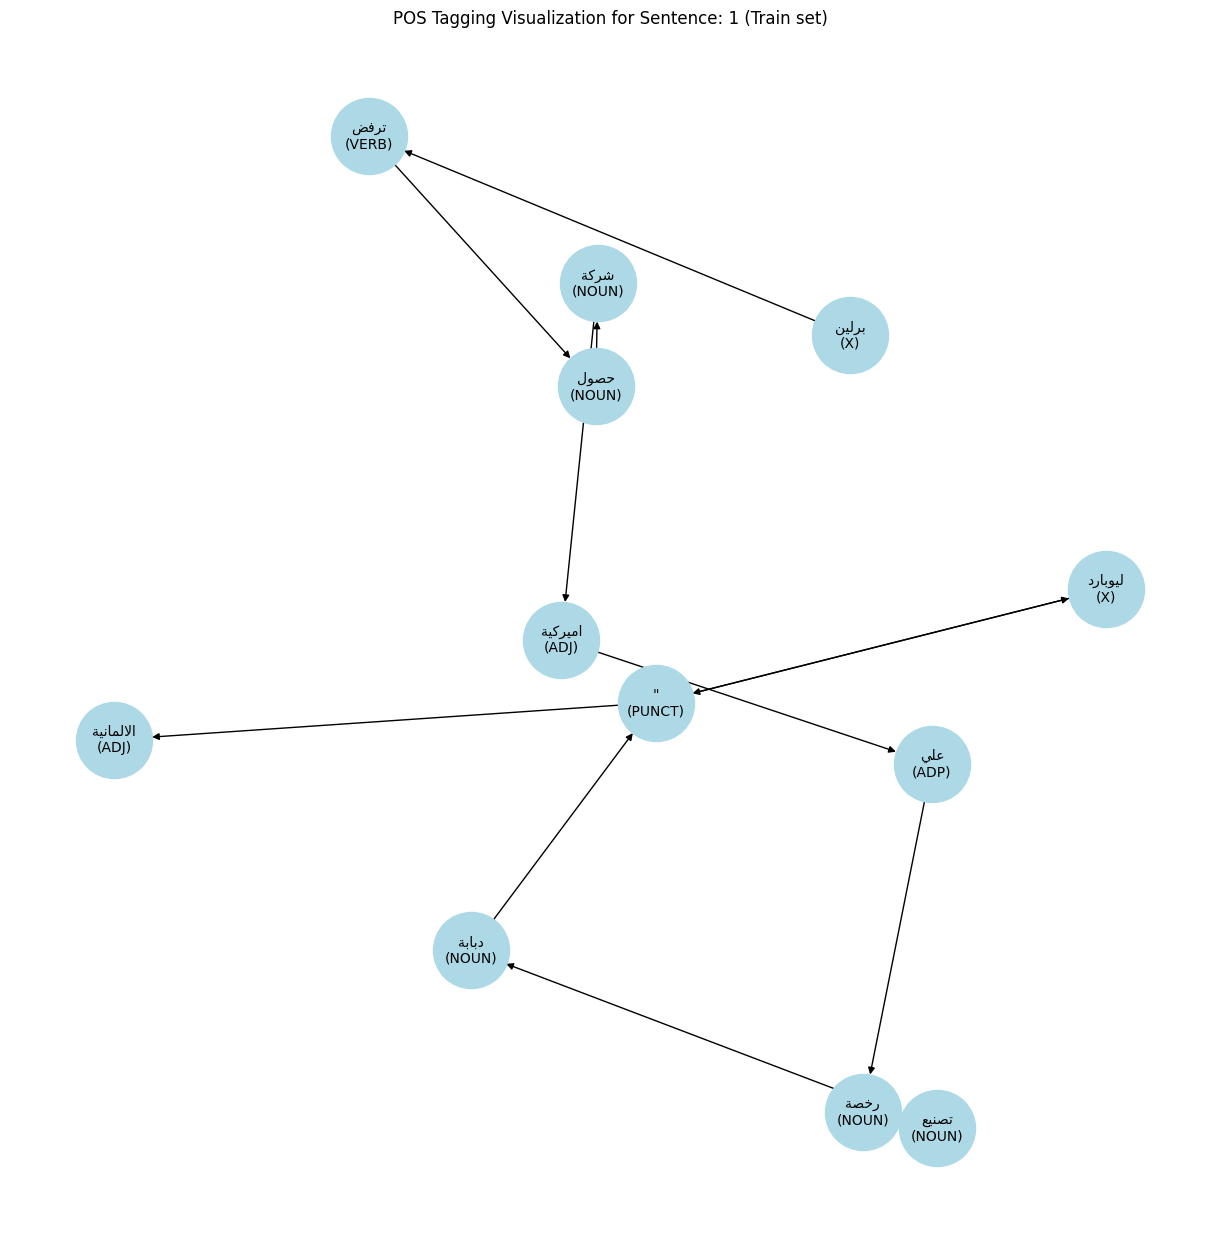

In [ ]:
create_graph_for_sentence(sentence_num=1, dataset='train')

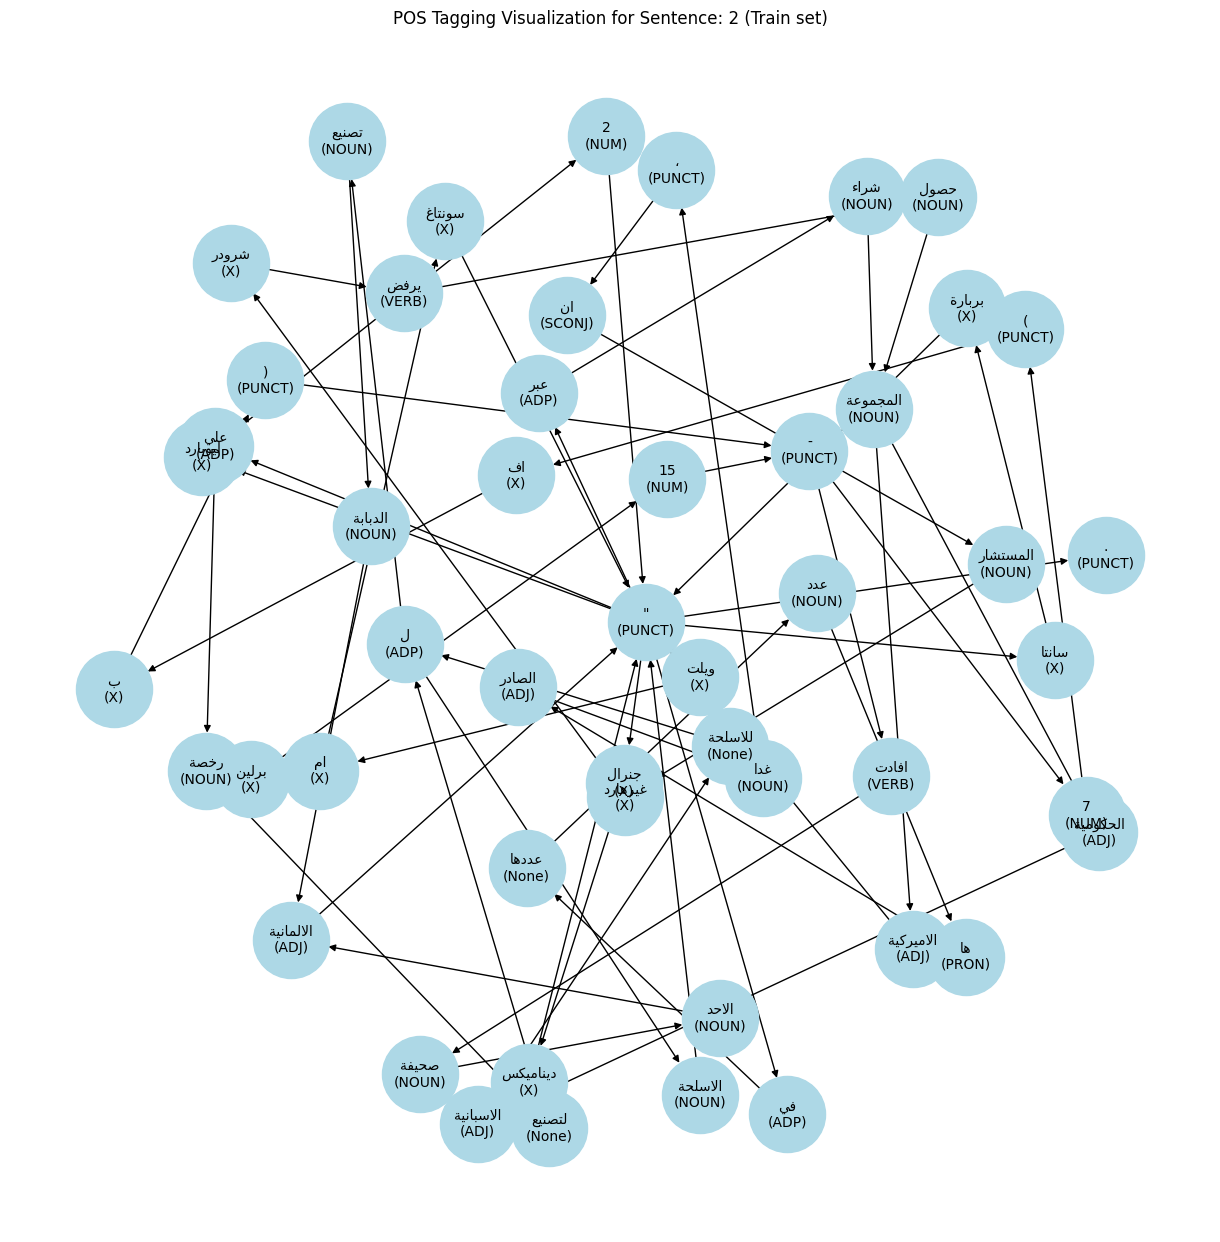

In [ ]:
# For the training dataset
create_graph_for_sentence(sentence_num=2, dataset='train')

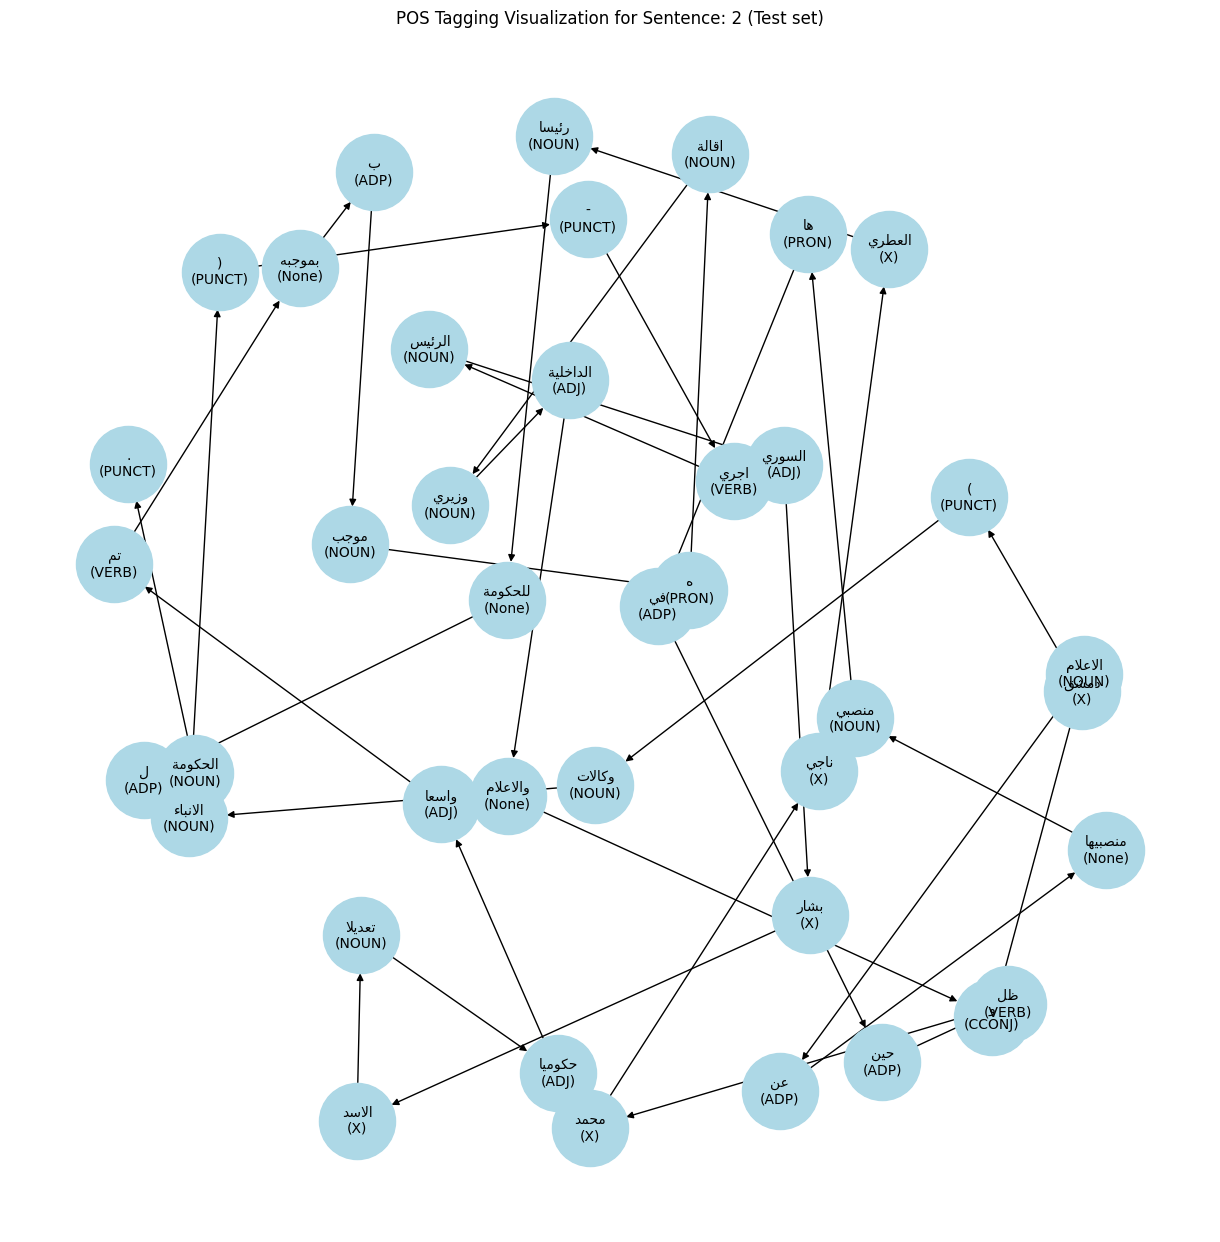

In [ ]:
# For the test dataset
create_graph_for_sentence(sentence_num=2, dataset='test')

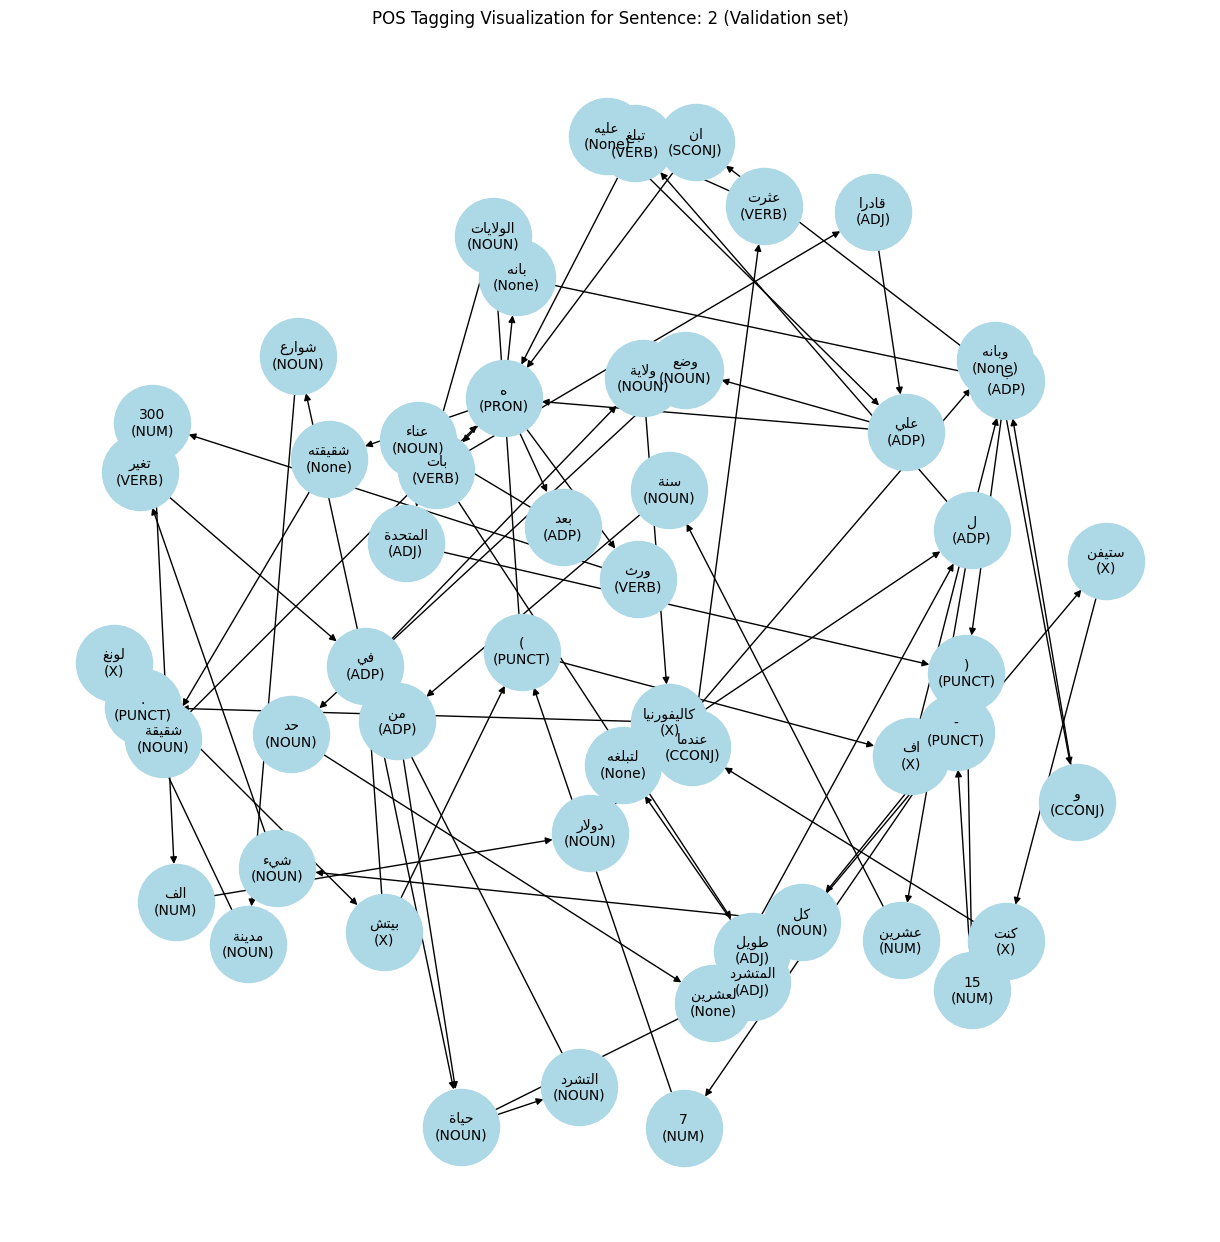

In [ ]:
# For the validation dataset
create_graph_for_sentence(sentence_num=2, dataset='validation')

In [ ]:
train_reshaped['POS'].value_counts()

,count
POS,
NOUN,73986
ADP,33423
ADJ,23361
PUNCT,17354
VERB,16706
CCONJ,15735
X,13610
PRON,8433
NUM,5905


Most Frequent: Nouns (73986) dominate, followed by adpositions (ADP, 33423) and adjectives (ADJ, 23361).

<Axes: xlabel='POS'>

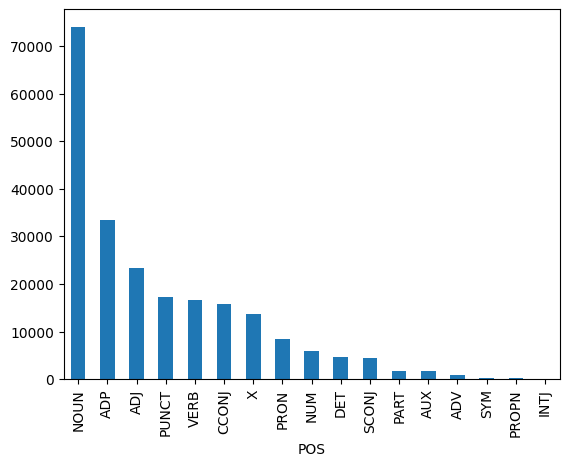

In [ ]:
train_reshaped["POS"].value_counts().plot(kind='bar')

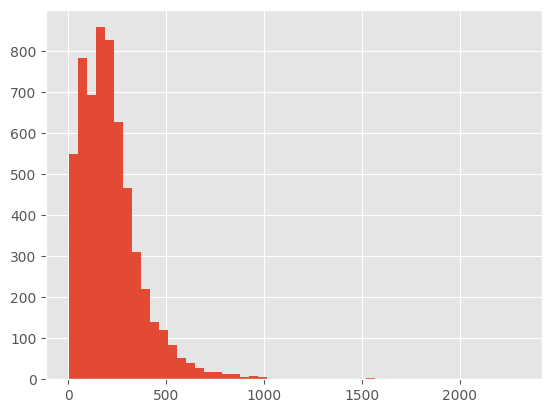

In [ ]:
plt.style.use('ggplot')
plt.hist([len(sent) for sent in train_df["Sentence"]], bins=50)
plt.show()

Most sentences are short: The peak of the distribution is around 0-100, indicating that the majority of sentences in your dataset are relatively short.

# Modeling

Since POS tagging is a sequence labeling task, LSTM models are a good choice for handling dependencies between words in a sentence.

## Prepare data for the model

 Find max length in our data

This step is essential as not all of the sentences will have the same length, so we find max length and make it the length for each sequence by padding the smaller sequences with zeros.

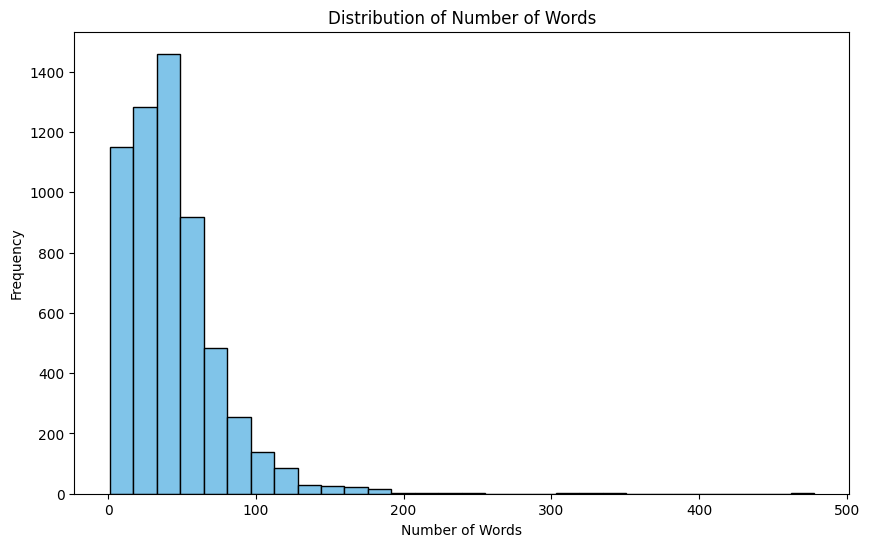

In [ ]:
train_df['token_count'] = train_df['Sentence'].apply(lambda x: len(x.split()))

# Plot the distribution of token counts
plt.figure(figsize=(10, 6))
plt.hist(train_df['token_count'], bins=30, color='#80C4E9', edgecolor='black')
plt.title('Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
train_df['token_count'].max()

478

In [ ]:
train_df['token_count'].min()

1

In [ ]:
# Tokenize words
word_tokenizer = Tokenizer(oov_token='<UNK>') # oov_token parameter is used to handle out-of-vocabulary (OOV) words during the tokenization process.
word_tokenizer.fit_on_texts(train_df['tokens'])

# Convert words to sequences
train_sequences = word_tokenizer.texts_to_sequences(train_df['tokens'])
val_sequences = word_tokenizer.texts_to_sequences(val_df['tokens'])
test_sequences = word_tokenizer.texts_to_sequences(test_df['tokens'])

# Get vocabulary size
vocab_size = len(word_tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 31363


In [ ]:
pos_encoder = LabelEncoder()

# Flatten POS tags and fit encoder
all_pos_tags = [tag for tags in train_df['pos_tags'] for tag in tags]
pos_encoder.fit(all_pos_tags)

# Encode POS tags
train_pos_sequences = [pos_encoder.transform(tags) for tags in train_df['pos_tags']]
val_pos_sequences = [pos_encoder.transform(tags) for tags in val_df['pos_tags']]
test_pos_sequences = [pos_encoder.transform(tags) for tags in test_df['pos_tags']]

# Number of unique tags
num_tags = len(pos_encoder.classes_)
print(f"Number of POS Tags: {num_tags}")

Number of POS Tags: 18


In [ ]:
max_len = train_df['token_count'].max()

# Pad sequences for words and POS tags
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

train_pos_padded = pad_sequences(train_pos_sequences, maxlen=max_len, padding='post')
val_pos_padded = pad_sequences(val_pos_sequences, maxlen=max_len, padding='post')
test_pos_padded = pad_sequences(test_pos_sequences, maxlen=max_len, padding='post')

In [ ]:
train_pos_onehot = to_categorical(train_pos_padded, num_classes=num_tags)
val_pos_onehot = to_categorical(val_pos_padded, num_classes=num_tags)
test_pos_onehot = to_categorical(test_pos_padded, num_classes=num_tags)

## Build the Model

I utilized Bidirectional LSTM for its ability to capture context from both past and future tokens within a sentence, essential for sequence labeling tasks.

In [ ]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input_layer)
bi_lstm = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.3))(embedding_layer)
output_layer = TimeDistributed(Dense(num_tags, activation='softmax'))(bi_lstm)
my_model = Model(inputs=input_layer, outputs=output_layer)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 478)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_13 (Embedding)             │ (None, 478, 128)            │       4,014,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 478, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 478, 18)             │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,282,258 (16.34 MB)

 Trainable params: 4,282,258 (16.34 MB)

 Non-trainable params: 0 (0.00 B)

## Model Results

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded, train_pos_onehot,
    validation_data=(val_padded, val_pos_onehot),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 639s 3s/step - accuracy: 0.9135 - loss: 0.3703 - val_accuracy: 0.9779 - val_loss: 0.0717
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 627s 3s/step - accuracy: 0.9815 - loss: 0.0660 - val_accuracy: 0.9931 - val_loss: 0.0264
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.9930 - loss: 0.0330 - val_accuracy: 0.9950 - val_loss: 0.0176
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.9951 - loss: 0.0233 - val_accuracy: 0.9955 - val_loss: 0.0153
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.9961 - loss: 0.0174 - val_accuracy: 0.9956 - val_loss: 0.0147
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - accuracy: 0.9968 - loss: 0.0136 - val_accuracy: 0.9956 - val_loss: 0.0147
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.9966 - loss: 0.0140 - val_accuracy: 0.9954 - val_loss: 0.0152
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.9968 - loss: 0.0130 - val_accu

The model is performing well, with an increasing training accuracy and decreasing training loss throughout the epochs.

The validation accuracy is consistently high, and the validation loss is also dropping, which indicates that the model is not overfitting.

In [ ]:
loss, accuracy = model.evaluate(test_padded, test_pos_onehot)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 510ms/step - accuracy: 0.9900 - loss: 0.0456
Test Loss: 0.034817736595869064
Test Accuracy: 0.9920463562011719


Overall, the model has demonstrated excellent performance with a high test accuracy of **99.20%** and low loss. The results indicate that the model is well-trained, effectively capturing the relationships in the data and generalizing well to unseen samples

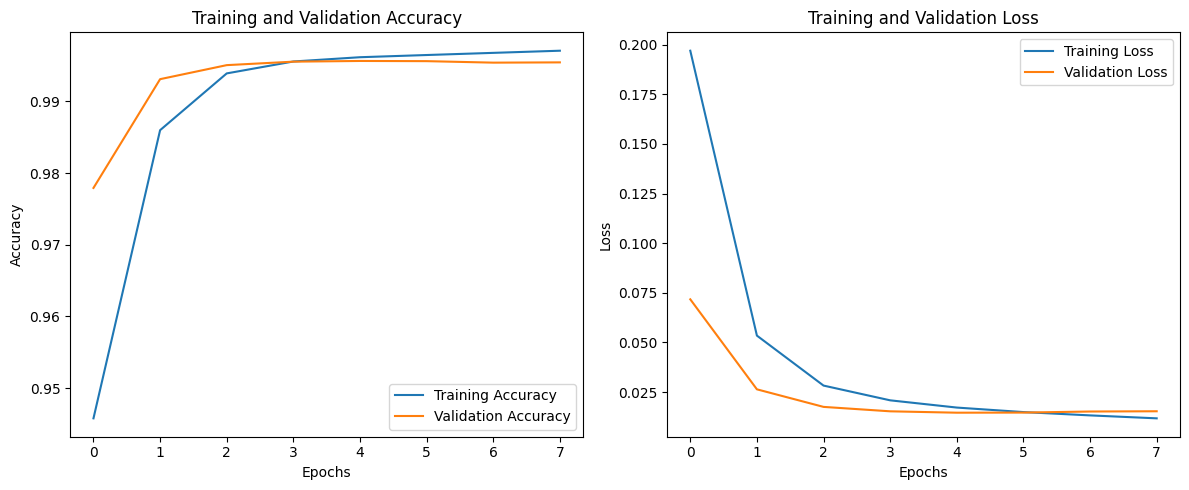

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The model achieved very high training, validation, and test accuracy, indicating it has learned the patterns in the data well.

The low values for both training and validation loss suggest that the model is not overfitting and is generalizing well

In [ ]:
# Get the model's predictions
y_pred = model.predict(test_padded)

# Convert one-hot encoded predictions back to POS tags
y_pred_tags = [pos_encoder.inverse_transform(np.argmax(pred, axis=-1)) for pred in y_pred]

# Convert one-hot encoded true labels back to POS tags
y_true_tags = [pos_encoder.inverse_transform(np.argmax(true, axis=-1)) for true in test_pos_onehot]

# Flatten lists for easier comparison
y_pred_flat = [tag for sent in y_pred_tags for tag in sent]
y_true_flat = [tag for sent in y_true_tags for tag in sent]

21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 840ms/step


# Error Analysis

In [ ]:
# Create a DataFrame for misclassifications
misclassifications = pd.DataFrame({
    'True POS': y_true_flat,
    'Predicted POS': y_pred_flat
})

# Filter only misclassifications
misclassifications = misclassifications[misclassifications['True POS'] != misclassifications['Predicted POS']]

# Display some examples of misclassifications
misclassifications.head()

,True POS,Predicted POS
3,ADJ,NOUN
478,X,NOUN
490,ADJ,X
493,None,None
500,None,None


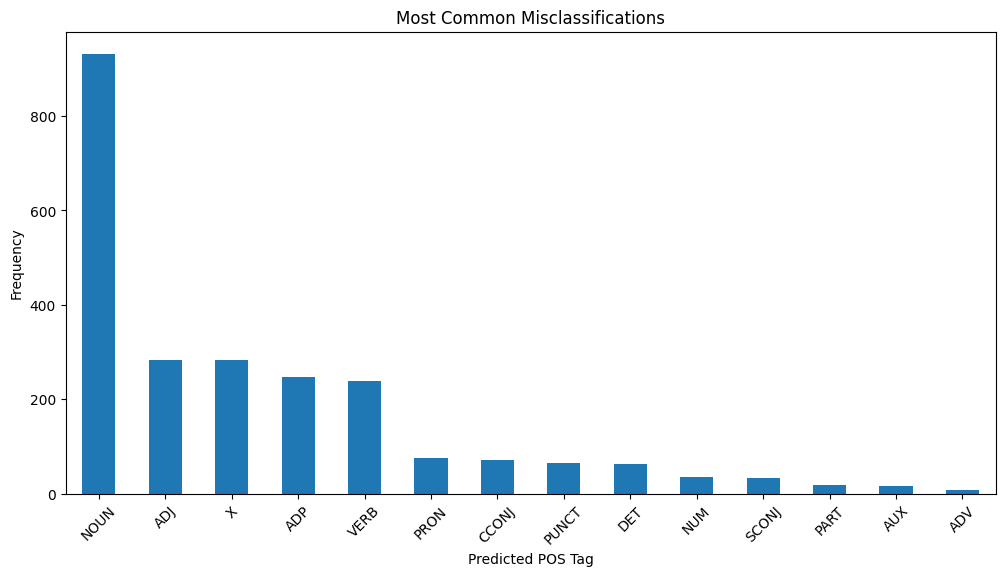

In [ ]:
# Count the frequency of misclassifications for each POS tag
misclassification_counts = misclassifications['Predicted POS'].value_counts()

# Plot the misclassifications as a bar plot
plt.figure(figsize=(12, 6))
misclassification_counts.plot(kind='bar')
plt.title('Most Common Misclassifications')
plt.xlabel('Predicted POS Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

NOUN is the most commonly misclassified tag, with a significant frequency of errors. This indicates that the model frequently confuses nouns with other categories, which could be due to their varied contexts in sentences.

ADJ (Adjective) and X (Unknown) tags also show notable misclassification rates, suggesting that adjectives are sometimes misidentified, possibly due to their dependence on context.

ADP (Adpositions) and VERB tags have moderate frequencies, indicating the model occasionally misclassifies prepositions and verbs.

Tags like NUM (Number), PUNCT (Punctuation), and AUX (Auxiliary) show minimal misclassifications, suggesting these categories are well-handled by the model.
